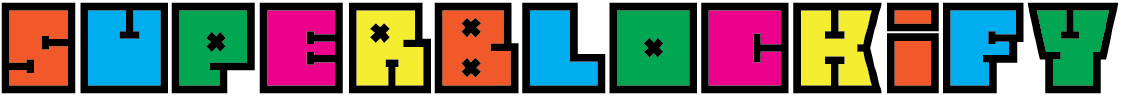

More info: [superblockify.city](https://superblockify.city)

# Distance calculation figures

This notebook creates figures to illustrate the distance calculation.

In [ ]:
from itertools import combinations

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

Graph:

In [ ]:
# Create planar graph, similar to a street network
G_2 = nx.DiGraph(nx.Graph(
    [
        (10, 11, {"weight": 1}),
        (11, 12, {"weight": 1}),
        (12, 13, {"weight": 1}),
        (13, 0, {"weight": 1.5}),
        (13, 14, {"weight": 1}),
        (14, 0, {"weight": 1}),
        (0, 10, {"weight": 1}),
        (0, 1, {"weight": 1}),
        (10, 1, {"weight": 1}),
        (1, 2, {"weight": 1}),
        (2, 3, {"weight": 1}),
        (3, 4, {"weight": 1.5}),
        (4, 5, {"weight": 1}),
        (5, 9, {"weight": 1}),
        (5, 6, {"weight": 1}),
        (7, 2, {"weight": 1}),
        (8, 7, {"weight": 0.5}),
        (7, 1, {"weight": 1}),
        (8, 9, {"weight": 0.7}),
        (6, 9, {"weight": 1}),
        (8, 4, {"weight": 1}),
        (9, 1, {"weight": 1}),
        (0, 18, {"weight": 0.4}),
        (18, 2, {"weight": 0.4}),
        (6, 15, {"weight": 0.8}),
        (15, 16, {"weight": 1}),
        (16, 17, {"weight": 1}),
        (17, 6, {"weight": 1}),
    ]
))
n_sparse = [0, 1, 2, 3, 4, 5, 6]
partitions = {
    "sparsified":
        {"nodes": n_sparse, "color": "black", "subgraph": G_2.subgraph(n_sparse)},
    "G_r": {"nodes": [7, 8, 9], "color": "crimson"},
    "G_g": {"nodes": [10, 11, 12, 13, 14], "color": "mediumseagreen"},
    "G_b": {"nodes": [15, 16, 17], "color": "dodgerblue"},
    "G_o": {"nodes": [18], "color": "darkorange"},
}
for name, part in partitions.items():
    if "subgraph" not in part:
        # subgraph for all edges from or to nodes in partition
        part["subgraph"] = G_2.edge_subgraph(
            [(u, v) for u, v in G_2.edges if u in part["nodes"] or v in part["nodes"]]
        )
    part["nodelist"] = part["subgraph"].nodes
    for node in part["nodes"]:
        G_2.nodes[node]["partition"] = part["color"]

In [ ]:
node_order = list(sorted(G_2.nodes))
n_sparse_indices = [node_order.index(n) for n in n_sparse]
part_name_order = [name for name in partitions.keys() if name != "sparsified"]
n_partition_indices_separate = [
    [node_order.index(n) for n in partitions[name]["nodes"]] for name in
    part_name_order
]
n_partition_indices = [n for part in n_partition_indices_separate for n in part]
node_order, n_sparse_indices, part_name_order, n_partition_indices_separate, \
    n_partition_indices

In [ ]:
[G_2.nodes[n]["partition"] for n in G_2.nodes]
# now sorted after node_order
[G_2.nodes[n]["partition"] for n in node_order]

In [ ]:

def plot_graph_seimpermeable(filepath, permitting=None):
    # Node positions
    pos = nx.kamada_kawai_layout(G_2)

    g_filtered = G_2.copy()

    g_filtered = nx.to_scipy_sparse_array(g_filtered, nodelist=node_order,
                                          format="coo")
    data, row, col = g_filtered.data, g_filtered.row, g_filtered.col
    # Remove edges between different partitions
    # (col, row in separate n_partition_indices_separate)
    for n_ind_1, n_ind_2 in combinations(n_partition_indices_separate, 2):
        mask = np.logical_and(np.isin(row, n_ind_1), np.isin(col, n_ind_2))
        mask = np.logical_or(mask,
                             np.logical_and(np.isin(row, n_ind_2),
                                            np.isin(col, n_ind_1)))
        data, row, col = data[~mask], row[~mask], col[~mask]

    # Remove edges from partition to sparse
    if permitting == 'in':
        mask = np.logical_and(np.isin(row, n_partition_indices),
                              np.isin(col, n_sparse_indices))
    elif permitting == 'out':
        mask = np.logical_and(np.isin(row, n_sparse_indices),
                              np.isin(col, n_partition_indices))
    data, row, col = data[~mask], row[~mask], col[~mask]
    g_filtered = csr_matrix((data, (row, col)),
                            shape=(len(node_order), len(node_order)))
    g_filtered = nx.from_scipy_sparse_array(g_filtered, create_using=nx.DiGraph)
    g_filtered = nx.relabel_nodes(g_filtered,
                                  {i: n for i, n in enumerate(node_order)})

    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw_networkx(g_filtered, with_labels=True,
                     node_color=[G_2.nodes[n]["partition"] for n in node_order],
                     font_color="white",
                     pos=pos,
                     ax=ax,
                     width=2,
                     arrowstyle="->",
                     arrowsize=15,
                     connectionstyle="arc3,rad=0.1",
                     )
    # Background transparent
    fig.patch.set_alpha(0)
    ax.patch.set_alpha(0)
    # Remove axis
    ax.axis("off")
    # Save
    plt.savefig(filepath, transparent=True, bbox_inches="tight")


plot_graph_seimpermeable("buildup_dist_calculation.pdf")
plot_graph_seimpermeable("buildup_dist_calculation_in.pdf", permitting='in')
plot_graph_seimpermeable("buildup_dist_calculation_out.pdf", permitting='out')